# Question 2

A data follows the following model for a time series:
- Use the notebook get GNP data.ipynb to get the data
- Use AR model on rgnp to predict the last 10 observations. 
    - Adjust the number of lags to consider using any model selection criteria you choose.
- Use VAR model (vector auto-regressive) to predict the last 10 observations of the data
- Replace the prediction models in the last two sections with corresponding LSTM models.
    - The LSTM models should be implemeted in PyTorch. 
    - You should optimize the hidden state size using validation set.
    
Hint: 
- For the regression model you may prefer to work on derivatives of the series. 
- You can check the order of derivation using Augmented Dickey-Fuller test.

In [6]:
import numpy as np
import pandas as pd

In [7]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
# print(df.shape)  # (123, 8)
df.tail()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


1. rgnp  : Real GNP.
2. pgnp  : Potential real GNP.
3. ulc   : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf   : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

## Using AR model for rgnp

### testing for stationarity

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['rgnp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.641882
p-value: 0.988604


In [10]:
result = adfuller(df['rgnp'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.427594
p-value: 0.000003


# Auxiliary code - hypothesis tests

In [11]:
from statsmodels.tsa.stattools import grangercausalitytests
test = 'ssr_chi2test'
test_result = grangercausalitytests(df[['rgnp','pgnp']], maxlag=10, verbose=False)
p_values = [round(test_result[i+1][0][test][1],4) for i in range(10)]
print('p_values = ',p_values)
print('min_p_value = ',np.min(p_values))


p_values =  [0.3256, 0.1849, 0.111, 0.2159, 0.2772, 0.0106, 0.0152, 0.0126, 0.0211, 0.0401]
min_p_value =  0.0106


In [16]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

r = adfuller(df['rgnp'], autolag='AIC')
output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
p_value = output['pvalue'] 
print(output)

{'test_statistic': 0.6419, 'pvalue': 0.9886, 'n_lags': 2, 'n_obs': 120}


In [18]:
v = df.rgnp.values
dv = np.diff(v)
r = adfuller(dv, autolag='AIC')
output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
p_value = output['pvalue'] 
print(output)



{'test_statistic': -5.4276, 'pvalue': 0.0, 'n_lags': 1, 'n_obs': 120}


<AxesSubplot:xlabel='date'>

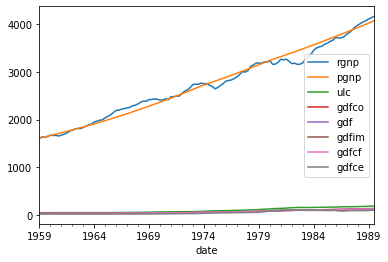

In [3]:
df.plot()

<AxesSubplot:xlabel='date'>

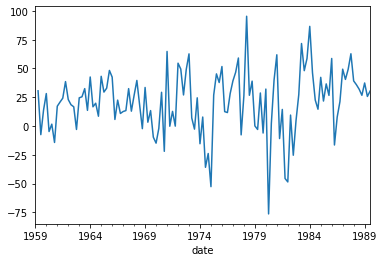

In [13]:
df['rgnp'].diff().plot()

In [12]:
df['rgnp']

date
1959-01-01    1606.4
1959-04-01    1637.0
1959-07-01    1629.5
1959-10-01    1643.4
1960-01-01    1671.6
               ...  
1988-07-01    4042.7
1988-10-01    4069.4
1989-01-01    4106.8
1989-04-01    4132.5
1989-07-01    4162.9
Name: rgnp, Length: 123, dtype: float64

In [ ]:
# AR example from: https://vitalflux.com/autoregressive-ar-models-with-python-examples/

P-value:  2.9633019848469267e-06


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


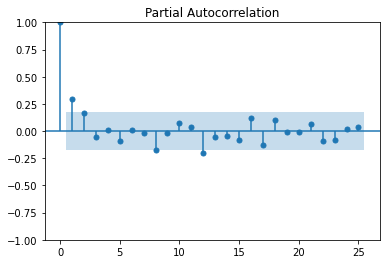

In [4]:
v=df['rgnp'].diff()[1:].values
#
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
#
from statsmodels.tsa.stattools import adfuller
#
# Run the test
#
df_stationarityTest = adfuller(v, autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])
#
# Next step is to find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data
#
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(v, lags=25)

In [5]:
#
# Create training and test data
#
train_data = v[:len(v)-10]
test_data = v[len(v)-10:]
#
# Instantiate and fit the AR model with training data
#
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(train_data, lags=1).fit()
#
# Print Summary
#
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  112
Model:                     AutoReg(1)   Log Likelihood                -522.681
Method:               Conditional MLE   S.D. of innovations             26.840
Date:                Fri, 24 Dec 2021   AIC                           1051.362
Time:                        14:55:12   BIC                           1059.491
Sample:                             1   HQIC                          1054.660
                                  112                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2338      3.098      4.595      0.000       8.163      20.305
y.L1           0.2661      0.092      2.894      0.004       0.086       0.446
                                    Roots           

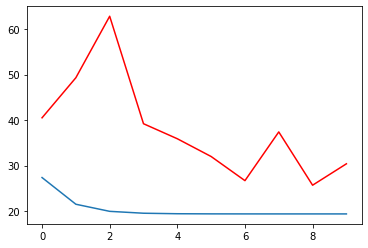

In [31]:
#
# Make the predictions
#
pred = ar_model.predict(start=len(train_data), end=(len(v)-1), dynamic=False)
#
# Plot the prediction vs test data
#
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(test_data, color='red')

In [ ]:
# var in: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/